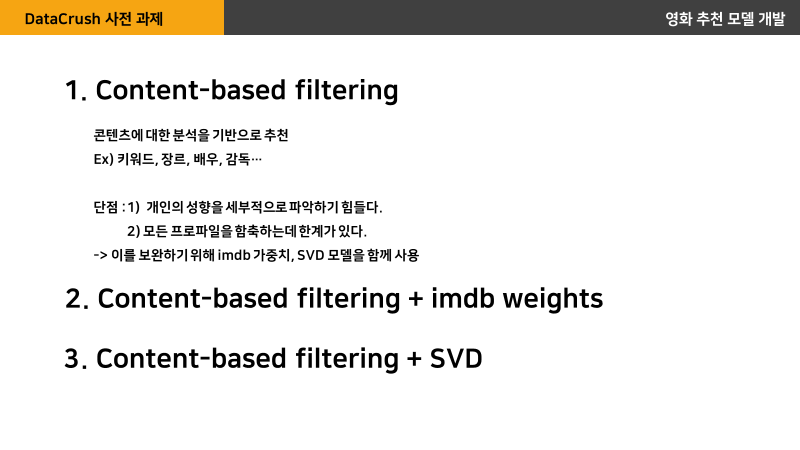

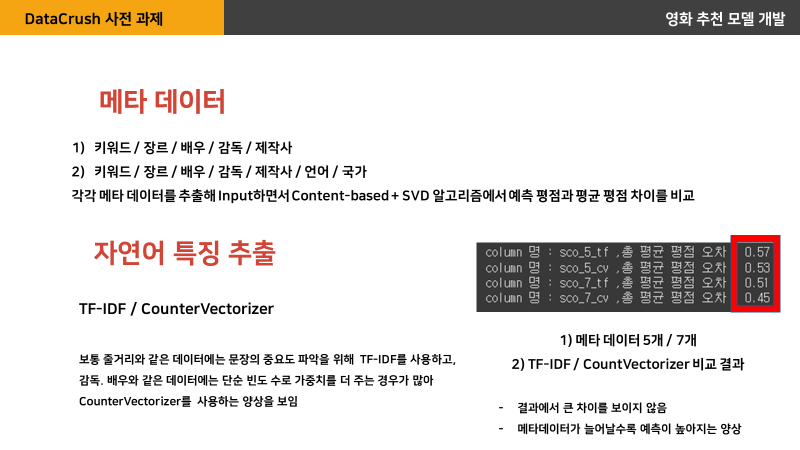

# 1 . 데이터 불러오기 및 전처리

## 1-1) 준비

- 사용한 Dataset
    - The Movies Dataset
    https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset

    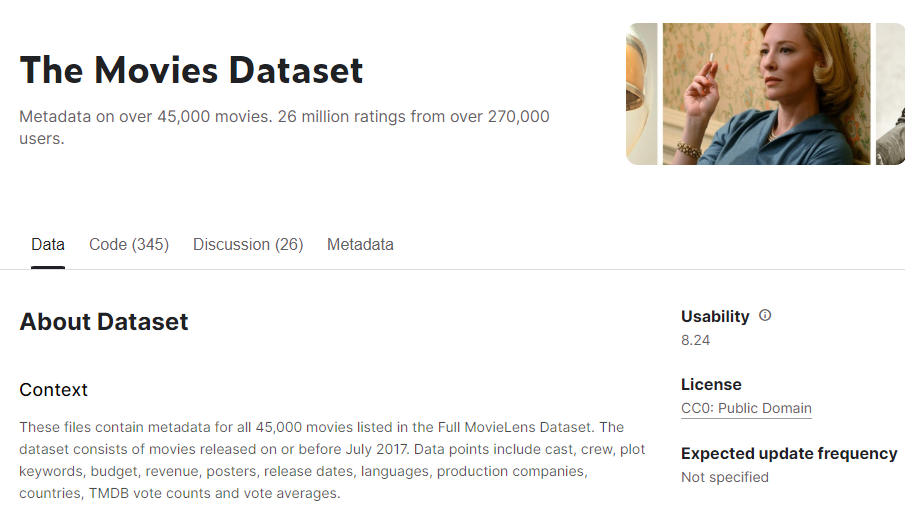

In [1]:
# %cd drive/MyDrive
# %mkdir kaggle
%cd drive/MyDrive/kaggle

/content/drive/MyDrive/kaggle


In [2]:
!pip install scikit-surprise

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from ast import literal_eval
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate, GridSearchCV
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 23.4 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633719 sha256=dc05b9183808f35275136b967e962fd62c15d5938d465ab8b355e4766fcc231d
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise




---


## 전처리 과정 skip 시 preprocessing.csv 활용



## 목차 2. Content-based filtering으로 이동


---



## 1-2) 데이터 수집 및 전처리

In [3]:
meta = pd.read_csv('./dataset/movies_metadata.csv', encoding='utf8', low_memory=False)
credit = pd.read_csv('./dataset/credits.csv', encoding='utf8', low_memory=False)
keyword = pd.read_csv('./dataset/keywords.csv', encoding='utf8', low_memory=False)

# 메모리 문제로 데이터 양 조절
links_small = pd.read_csv('./dataset/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [4]:
# 제목이 없는 데이터 제거
def clean_title(df):
    # 결측치가 있을 경우, 해당 id를 lst로 만들기
    id = [idx for idx, title in enumerate(meta['title']) if pd.isna(title) == True]
   
    return id

In [5]:
# 각 키워드, 크레딧 Dataframe과 병합
def merge_DataFrame(df):

    # 제목이 없는 결측치 제거
    df = df.drop(clean_title(df))

    # join을 위해 id type 통일 변경
    df['id'] = df['id'].astype('int')

    # id 기준으로 데이터 병합
    movie = df.merge(credit, on='id')
    movie = movie.merge(keyword, on='id')

    # 메모리 issue로 데이터 수량 조절
    movie = movie[movie['id'].isin(links_small)]

    return movie

In [6]:
# date 열에서 연도만 따로 추출
def extract_year(df):

    movie = merge_DataFrame(df)

    # release date에서 연도만 뽑아내기                  # errors='coerce' => 오류 시 Nan 값으로 대체
    movie['year'] = pd.to_datetime(movie['release_date'], errors='coerce')
    movie['year'] = movie['year'].apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

    # 이상치 제거
    err = movie[movie['year'] == 'NaT'].index.tolist()
    movie = movie.drop(err, axis=0)

    return movie

In [7]:
# 감독 이름 추출
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

# 국가 정보 추출 (ex: US)
def get_country(x):
    for i in x:
        return i['iso_3166_1']


# 언어 정보 추출 (ex: us)
def get_languages(x):
    for i in x:
        return i['iso_639_1']

## keyword, genres 등 여러 개를 포함한 데이터의 경우
## 최대 3개씩만 가져오게 만드는 함수 생성
def get_list(x):
    # x가 list인지 확인
    if isinstance(x, list):
        names = [i['name'] for i in x]
        # 3개 이상이면 3개까지만 반환, 아니면 전체 반환
        if len(names) > 3:
            names = names[:3]
        return names

    # 데이터 결측 시 빈 리스트 반환
    return []

# 이름 간 공백 제거 
# (ex) Johnny Depp 과 Johnny Galecki 가 유사성이 나오지 않게끔 작업)
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        # 값이 없으면, ''값 대체
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [8]:
def apply(df):

    movie = extract_year(df)

    features = ['cast', 'crew', 'keywords', 'genres', 'production_companies', "production_countries", 'spoken_languages']

    # string으로 저장된 dict를 실제 dict로 변경 
    for feature in features:
        movie[feature] = movie[feature].apply(literal_eval)

    # 각각 최대 3개씩만 값을 추출해 새로 저장
    features = ['cast', 'keywords', 'genres', 'production_companies']

    for feature in features:
        movie[feature] = movie[feature].apply(get_list)

    # 감독, 국가, 언어 열 생성
    movie['director'] = movie['crew'].apply(get_director)
    movie['country'] = movie['production_countries'].apply(get_country)
    movie['language'] = movie['spoken_languages'].apply(get_languages)

    # 새로 생성한 열들에 대해 결측치 빈 str 값으로 대체
    lst = ['director', 'country', 'language']

    for col in lst:
        movie[col] = movie[col].fillna('')

    # 단어 간 공백 제거 함수 적용
    features = ['cast', 'keywords', 'director', 'genres', 'production_companies']

    for feature in features:
        movie[feature] = movie[feature].apply(clean_data)

    # train과 test를 year 열의 index 기준으로 나누기 위해
    # year 기준으로 sorting하고 index reset
    movie['year'] = pd.to_numeric(movie['year'])

    movie = movie.sort_values('year')
    movie.reset_index(drop=True, inplace=True)

    return movie

#### 유사도를 측정할 메타데이터 조합
def create_soup(x):
                # 1개 이상의 요소들은 join으로 합쳐주기
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres']) + ' ' + ' '.join(x['production_companies']) + ' ' + x['language']  + ' ' + x['country'] 

- 활용할 메타 데이터

    - 키워드 / 출연진 / 감독 / 장르 / 제작사 / 국가 / 언어
    - 키워드 / 출연진 / 감독 / 장르 / 제작사

    - 국가, 언어 포함 여부에 대한 모델의 평균 예측 오차를 비교
    

In [9]:
movie = apply(meta)

# 벡터라이저에 대입할 메타 데이터를 합치는 과정
movie['soup'] = movie.apply(create_soup, axis=1)

In [10]:
movie.to_csv('./dataset/preprocessing_movie.csv', index=False)

# 2 . Content-based filtering 


In [11]:
movie = pd.read_csv('./dataset/preprocessing_movie.csv')

## 2-1) Train-test split

In [12]:
# year 기준으로 sorting이 되어 있으니, 2015년 데이터의 마지막 인덱스를 가져옴
split_idx = movie[movie['year'] == 2015].index.tolist()[-1]

# 2015년 이전 데이터 train, 이후 데이터는 test
train = movie.iloc[:split_idx, :]
test = movie.iloc[split_idx:, :]

# test index는 9139 부터 시작, reset
test = test.reset_index(drop=True)

# 테스트 이후 오류 발견, 오류 발생 데이터 제거
test = test.drop([6, 7, 11, 19, 26, 78], axis=0)

# test data index가 9139부터 시작하기 때문에 reset
test = test.reset_index(drop=True)

print(f'Train shape : {train.shape}, Test shape : {test.shape}')
print(f'Train index : {train.index}, Test index : {test.index}')

Train shape : (9138, 32), Test shape : (75, 32)
Train index : RangeIndex(start=0, stop=9138, step=1), Test index : RangeIndex(start=0, stop=75, step=1)


## 2-2) 유사도 측정

In [16]:
def content_based_filtering(title, cos):
    ## test 할 행을 title과 일치하는 인덱스로 가져와서 train 데이터에 추가
    try:
        index = test[test['title'] == title].index.tolist()[0]
    except:
        print('해당 영화가 존재하지 않습니다.')

    new_train = train.append(test.loc[index])
    new_train = new_train.reset_index(drop=True)

    # TF-IDF / CounterVectorizer 선택
    if cos == 'tf':
        tfidf = TfidfVectorizer(stop_words='english')
        tfidf_matrix = tfidf.fit_transform(new_train['soup'])

        cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    elif cos == 'cv':
        count = CountVectorizer(stop_words='english')
        count_matrix = count.fit_transform(new_train['soup'])

        cosine_sim = cosine_similarity(count_matrix, count_matrix)

    # title 별 index 매칭하는 series 생성
    indices = pd.Series(new_train.index, index=new_train['title'])

    # Train 내 중복 값이 존재할 경우, 새로 들어온 값의 idx 사용하기
    try:
        idx = indices[title][-1]
    except:
        idx = indices[title]

    # 해당 영화가 포함된 코사인 유사도 행렬 가져오기
    sim_scores = list(enumerate(cosine_sim[idx]))

    # 유사 점수에 기반해 영화 내림차순 정렬
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # 가장 유사한 10개 점수 가져오기
    sim_scores = sim_scores[1:21]

    # 해당 영화의 인덱스 가져오기
    movie_indices = [i[0] for i in sim_scores]

    # 상위 10개 영화 제목 가져오기
    return new_train['title'].iloc[movie_indices]

## 2-3) test data로 검증

In [14]:
# 검증 시 test title을 랜덤으로 가져오기
def random_test_title():

    random_idx = random.randrange(test.index[0], test.index[-1])
    name = test['title'][random_idx]
    
    return name

In [17]:
# TF-IDF 유사도
TF_IDF = 'tf'
# CounterVectorizer
CntVect = 'cv'
# Test title random으로 가져오기
random_title = random_test_title()

print('-----------------Content-based filtering ---------------------')
print()
print('----------------------TF-IDF 사용 시 -------------------------')
print()
print(f'Test title : {random_title}')
print(content_based_filtering(random_title, TF_IDF))
print()
print('-----------------ConterVectorizer 사용 시 ---------------------')
print()
print(f'Test title : {random_title}')
print(content_based_filtering(random_title, CntVect))

-----------------Content-based filtering ---------------------

----------------------TF-IDF 사용 시 -------------------------

Test title : Keanu
[(4306, 0.161463166709449), (4988, 0.1225681864936727), (6658, 0.11724250215215098), (1883, 0.11334288878563428), (6170, 0.10987066544386269), (4370, 0.1027433434777421), (7520, 0.1017723889881611), (8053, 0.10079603511279578), (3010, 0.10072914196225474), (8331, 0.10023222272325281), (5572, 0.09971098971420343), (8213, 0.09574396704215639), (9030, 0.09524481860244934), (8473, 0.09524262352913884), (1586, 0.0944933012357021), (7421, 0.09435625921499095), (2353, 0.09007276803249807), (7585, 0.08889442250049616), (544, 0.08794798126618339), (6542, 0.08792303412071995)]
(0.08792303412071995, 'The Whole Ten Yards')

-----------------ConterVectorizer 사용 시 ---------------------

Test title : Keanu
[(7520, 0.3481553119113957), (3171, 0.3333333333333334), (4459, 0.3333333333333334), (4587, 0.3333333333333334), (4880, 0.3333333333333334), (5807, 0.33333

# 3 . Collaborative Filtering

## 3-1) SVD, 잠재요인 기반 추천 알고리즘

In [ ]:
reader = Reader()

ratings = pd.read_csv('./dataset/ratings_small.csv')

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# SVD 모듈을 사용하여 잠재요인 협업필터링을 사용함
svd = SVD(random_state=42)

# 5-fold cross-validation을 사용
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9000  0.9015  0.8910  0.8967  0.8910  0.8960  0.0044  
MAE (testset)     0.6895  0.6958  0.6865  0.6916  0.6874  0.6902  0.0033  
Fit time          4.93    4.77    4.81    4.83    4.84    4.83    0.05    
Test time         0.25    0.15    0.25    0.18    0.26    0.22    0.05    


{'fit_time': (4.928815603256226,
  4.774332046508789,
  4.8057966232299805,
  4.827341079711914,
  4.837718486785889),
 'test_mae': array([0.68954742, 0.69579964, 0.68649423, 0.6915572 , 0.68744646]),
 'test_rmse': array([0.90003711, 0.90146651, 0.89097604, 0.89674553, 0.89096294]),
 'test_time': (0.24867868423461914,
  0.14507246017456055,
  0.25344371795654297,
  0.17873644828796387,
  0.25668859481811523)}

- 평균 RMSE score = 0.895~ 0.897

In [ ]:
# 파라미터 사전적으로 정의
param_grid = {'n_epochs':[20, 40], 'n_factors':[50, 100, 200]}

# GridSearchCV 적용
grid = GridSearchCV(SVD, param_grid=param_grid,
                   measures=['rmse','mae'], cv=5)

# GridSearchCV로 데이터 학습시키기
grid.fit(data)

# 최적의 점수 및 파라미터 적용
best_sco = grid.best_score['rmse']
best_params = grid.best_params['rmse']

# 최고의 score와 그 때의 파라미터 출력
print(f'최적의 RMSE score : {best_sco}')
print(f'최적의 파라미터 : {best_params}')

최적의 RMSE score : 0.8933108317257435
최적의 파라미터 : {'n_epochs': 20, 'n_factors': 50}


- 파라미터를 늘려서 테스트를 해보고 싶지만, 시간 소요가 많이 걸리고, score에서 드라마틱한 차이를 보이지 않음. 
- Default 값이 오히려 RMSE가 조금 더 높게 나옴
- Default 값으로 사용

In [ ]:
def get_unseen_lst(ratings, movies, userId):
    
    # 특정 유저가 본 영화 id들을 리스트로 할당
    seen_movies = ratings[ratings['userId']==userId]['movieId'].tolist()

    # 전체 movie id 리스트로 할당
    total_movies = movies['id'].tolist()
    
    # 전체 영화 - 특정 유저가 본 영화 = 안 본 영화 id
    unseen_movies = [movie for movie in total_movies if movie not in seen_movies]
    print(f'특정 {userId}번 유저가 본 영화 수: {len(seen_movies)}\n추천한 영화 개수: {len(unseen_movies)}\n전체 영화수: {len(total_movies)}')

    return unseen_movies


def recommend_movie_svd(svd, userId, unseen_movies, top_n=10):

    # 선택한 유저의 평점이 없는 영화들에 대해 평점 예측
    predictions = [svd.predict(str(userId), str(id)) for id in unseen_movies]
    
    # 예측 평점을 기준으로 sorting
    def sorting_est(pred):
        return pred.est
    
    # 내림차순으로 정렬, inplace=True가 defalut 값
    predictions.sort(key=sorting_est, reverse=True)

    # 상위 n개의 예측값들만 할당
    top_predictions = predictions[:top_n]
    
    # top_predictions에서 movie id, rating, movie title 각 뽑아내기
    top_movie_ids = [int(pred.iid) for pred in top_predictions]
    top_movie_ratings = [pred.est for pred in top_predictions]
    top_movie_titles = movie[movie.id.isin(top_movie_ids)]['title']

    # 위 3가지를 튜플로 담기
    top_movie_preds = [(ids, rating, title) for ids, rating, title in zip(top_movie_ids, top_movie_ratings, top_movie_titles)]
    
    return top_movie_preds

In [ ]:
### userid == 9 번에게 맞는 추천 영화 뽑기
# 특정 유저가 보지 않은 영화 lst 생성
unseen_lst = get_unseen_lst(ratings, movie, 9)
# 평점 예측 및 상위 top_n = 10 개 가져오기
top_movies_preds = recommend_movie_svd(svd, 9, unseen_lst, top_n=10)

print()
print('#'*8, 'Top-10 추천영화 리스트', '#'*8)

# Top ~ 10의 영화 title과 평점 출력
for top_movie in top_movies_preds:
    print('* 추천 영화 이름: ', top_movie[2])
    print('* 해당 영화의 예측평점: ', top_movie[1])
    print()

특정 9번 유저가 본 영화 수: 45
추천한 영화 개수: 9197
전체 영화수: 9219

######## Top-10 추천영화 리스트 ########
* 추천 영화 이름:  A Trip to the Moon
* 해당 영화의 예측평점:  3.5438478076096196

* 추천 영화 이름:  The Birth of a Nation
* 해당 영화의 예측평점:  3.5438478076096196

* 추천 영화 이름:  Intolerance: Love's Struggle Throughout the Ages
* 해당 영화의 예측평점:  3.5438478076096196

* 추천 영화 이름:  20,000 Leagues Under the Sea
* 해당 영화의 예측평점:  3.5438478076096196

* 추천 영화 이름:  The Immigrant
* 해당 영화의 예측평점:  3.5438478076096196

* 추천 영화 이름:  A Dog's Life
* 해당 영화의 예측평점:  3.5438478076096196

* 추천 영화 이름:  Billy Blazes, Esq.
* 해당 영화의 예측평점:  3.5438478076096196

* 추천 영화 이름:  The Mark of Zorro
* 해당 영화의 예측평점:  3.5438478076096196

* 추천 영화 이름:  The Golem: How He Came Into the World
* 해당 영화의 예측평점:  3.5438478076096196

* 추천 영화 이름:  The Cabinet of Dr. Caligari
* 해당 영화의 예측평점:  3.5438478076096196



# 4 . Hybrid Filtering

## 4-1) Content-based + imdb weights

### 4-1-1) 가중치 계산 및 유사도 측정

In [ ]:
vote_counts = train[train['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = train[train['vote_average'].notnull()]['vote_average'].astype('int')

# 평균 리뷰 점수 / 리뷰 수 지정
def vote_mean_quantile(qt):

    C = vote_averages.mean()
    m = vote_counts.quantile(qt)

    return C, m

# imdb 가중치 적용
def weighted_rating(x):
                # 최저 리뷰 수 분위 지정 (vote_counts.quantile(0.6) == 최소 154 이상)
    C, m = vote_mean_quantile(0.6)
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

def Content_based_imdb_weights(title, cos):

    ## test 할 행을 title과 일치하는 인덱스로 가져와서 train 데이터에 추가
    try:
        index = test[test['title'] == title].index.tolist()[0]
    except:
        print('해당 영화가 존재하지 않습니다.')

    new_train = train.append(test.loc[index])
    new_train = new_train.reset_index(drop=True)

    # TF-IDF / CounterVectorizer 선택
    if cos == 'tf':
        tfidf = TfidfVectorizer(stop_words='english')
        tfidf_matrix = tfidf.fit_transform(new_train['soup'])

        cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    elif cos == 'cv':
        count = CountVectorizer(stop_words='english')
        count_matrix = count.fit_transform(new_train['soup'])

        cosine_sim = cosine_similarity(count_matrix, count_matrix)


    # title 별 index 매칭하는 series 생성
    indices = pd.Series(new_train.index, index=new_train['title'])

    # Train 내 중복 값이 존재할 경우, 새로 들어온 값의 idx 사용하기
    try:
        idx = indices[title][-1]
    except:
        idx = indices[title]

    # 해당 영화가 포함된 코사인 유사도 행렬 가져오기
    sim_scores = list(enumerate(cosine_sim[idx]))
 
    # 유사 점수에 기반해 영화 내림차순 정렬
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # 가장 유사한 20개 점수 가져오기
    sim_scores = sim_scores[1:26]

    # 해당 영화의 인덱스 가져오기
    movie_indices = [i[0] for i in sim_scores]

    # 영화 index에 해당하는 행만 가져오기
    movies = new_train.copy().iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]

    # Null 값 제외한 리뷰 수, 평균 평점 변수 생성
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')

    # 최저 리뷰 수 ((vote_counts.quantile(0.6) == 최소 154개 이상)
    C, m = vote_mean_quantile(0.6)
    qualified = movies.copy()[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]

    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')

    # 가중치 함수 적용 및 새 column 생성, 가중치 기준 내림차순 정렬
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    qualified.columns = ['제목', '리뷰 수', '평균 평점', '연도', '가중치 점수']

    return qualified

### 4-1-2) test data로 검증

In [ ]:
# TF-IDF 유사도
TF_IDF = 'tf'
# CounterVectorizer
CntVect = 'cv'
random_title = random_test_title()

print('-----------------Hybrid filtering ---------------------')
print()
print('-----------------Content-based + imdb weights----------')
print()
print('-----------------TF-IDF 사용 시 ---------------------')
print()
print(f'Test title : {random_title}')
print(Content_based_imdb_weights(random_title, TF_IDF))
print()
print('-----------------ConterVectorizer 사용 시 ---------------------')
print()
print(f'Test title : {random_title}')
print(Content_based_imdb_weights(random_title, CntVect))

-----------------Hybrid filtering ---------------------

-----------------Content-based + imdb weights----------

-----------------TF-IDF 사용 시 ---------------------

Test title : The Jungle Book
                         제목  리뷰 수  평균 평점    연도    가중치 점수
7513               Iron Man  8951      7  2008  6.981932
7897         Shutter Island  6559      7  2010  6.975492
8887             Maleficent  4607      7  2014  6.965437
8181                   Hugo  2197      7  2011  6.929961
8919                   Chef  1203      7  2014  6.878544
2232  The NeverEnding Story  1031      7  1984  6.860871
5990        Treasure Planet   980      7  2002  6.854597
4074                  Balto   423      7  1995  6.713500
3452                   Rudy   187      7  1993  6.513459
8001             Iron Man 2  6969      6  2010  5.998111

-----------------ConterVectorizer 사용 시 ---------------------

Test title : The Jungle Book
                                                     제목  리뷰 수  평균 평점    연도  \
7938    

## 4-2) Content-based + SVD

### 4-2-1) userid 포함 mapping

In [ ]:
# int 변환
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [ ]:
# userid, movieid와 title을 mapping
def mapping():
    id_map = pd.read_csv('./dataset/links_small.csv')[['movieId', 'tmdbId']]
    id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
    id_map.columns = ['movieId', 'id']
    id_map = id_map.merge(movie[['title', 'id']], on='id').set_index('title')

    indices_map = id_map.set_index('id')

    return id_map, indices_map

### 4-2-2) cosine 유사도 및 SVD 알고리즘 적용

In [ ]:
def Content_based_SVD(userId, title, cos):
    
    ## test 할 데이터를 인덱싱해서 가져와서 train에 append
    try:
        index = test[test['title'] == title].index.tolist()[0]
    except:
        print('해당 영화가 존재하지 않습니다.')

    new_train = train.append(test.loc[index])
    new_train = new_train.reset_index(drop=True)

    ## TF-IDF / CounterVectorizer를 선택
    if cos == 'tf':
        tfidf = TfidfVectorizer(stop_words='english')
        tfidf_matrix = tfidf.fit_transform(new_train['soup'])

        cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    elif cos == 'cv':
        count = CountVectorizer(stop_words='english')
        count_matrix = count.fit_transform(new_train['soup'])

        cosine_sim = cosine_similarity(count_matrix, count_matrix)

    # userid, movieid, title을 mapping한 변수 가져오기
    id_map, indices_map = mapping()

    # title 별 index 매칭하는 series 생성
    indices = pd.Series(new_train.index, index=new_train['title'])
    
    # # Train 내 중복 값이 존재할 경우, 새로 들어온 값의 idx 사용하기
    try:
        idx = indices[title][-1]
    except:
        idx = indices[title]

    # 해당 영화가 포함된 코사인 유사도 행렬 가져오기
    sim_scores = list(enumerate(cosine_sim[idx]))
 
    # 유사 점수에 기반해 영화 내림차순 정렬
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # 가장 유사한 25개 점수 가져오기
    sim_scores = sim_scores[1:26]
   
    # 해당 영화의 인덱스 가져오기
    movie_indices = [i[0] for i in sim_scores]

    # 리뷰 점수 0 ~ 10으로 되어 있어서 예측 평점과 유사하게 0 ~ 5 분포로 통일
    new_train['vote_average'] = new_train['vote_average'] / 2

    # 유사도 상위 25개 행 가져오기
    movies = new_train.copy().iloc[movie_indices]
    movies = movies[['title', 'vote_count', 'vote_average', 'year', 'id']]

    # SVD 알고리즘으로 예측되는 평가 점수 열 생성 및 예측 점수 기준 내림차순 정렬
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)

    # 영화의 평균 평점과 SVD로 예측한 평점의 차이 계산 열 생성
    movies['평균평점 - 예측평점'] = movies['vote_average'] - movies['est']
    movies = movies[['title', 'vote_count', 'vote_average', 'est', '평균평점 - 예측평점']]
    movies.columns = ['제목', '리뷰 수', '평균평점', '예측평점', '평균평점 - 예측평점']

    # 예측한 영화들(25개)의 전체 평균 평점과 예측 평점의 평균 출력
    total_avg_pred_score = round(movies['평균평점 - 예측평점'].mean(), 2)
    print(f'전체 평균 예측 평점 오차 : {total_avg_pred_score:.2f}')

    return movies.head(10)
    # return total_avg_pred_score

### 4-2-3) test data로 검증

In [ ]:
# TF-IDF 유사도
TF_IDF = 'tf'
# CounterVectorizer
CntVect = 'cv'
random_title = random_test_title()


print('-----------------  Hybrid Filtering  ---------------------')
print()
print('-----------------Content-based + SVD----------------------')
print()
print('-----------------TF-IDF 사용 시 ---------------------')
print()
print(f'Test title : {random_title}')
print(Content_based_SVD(1, random_title, TF_IDF))
print()
print('-----------------ConterVectorizer 사용 시 ---------------------')
print()
print(f'Test title : {random_title}')
print(Content_based_SVD(1, random_title, CntVect))

-----------------  Hybrid Filtering  ---------------------

-----------------Content-based + SVD----------------------

-----------------TF-IDF 사용 시 ---------------------

Test title : X-Men: Apocalypse
전체 평균 예측 평점 오차 : 0.32
                              제목     리뷰 수  평균평점      예측평점  평균평점 - 예측평점
8204          X-Men: First Class   5252.0  3.55  3.435959     0.114041
9086                     Ant-Man   6029.0  3.50  3.374513     0.125487
8001                  Iron Man 2   6969.0  3.30  3.092671     0.207329
8297                The Avengers  12000.0  3.70  3.069294     0.630706
8948  X-Men: Days of Future Past   6155.0  3.75  3.065450     0.684550
6096                    Timeline    324.0  2.70  2.950217    -0.250217
6220                          X2   3572.0  3.40  2.950162     0.449838
1631    The Island of Dr. Moreau     33.0  2.70  2.947886    -0.247886
8361            The Hunger Games   9634.0  3.45  2.944537     0.505463
5292                       X-Men   4172.0  3.40  2.907947     0.4

### 4-2-4) 자연어 처리 / 메타 데이터  별 평균 - 예측 오차 비교

In [ ]:
# 메타데이터 5개일 때, 7개일 때 분류 / 세번째 인자를 5, 7로 input
def score2csv(metalen):
    score_tf = []
    score_cv = []

    ttt = test['title'].tolist()
    a = 0

    for i in ttt:
        a+=1
        print(a, '번째 data append 중')
        try:
            score_tf.append(Content_based_SVD(1, i, TF_IDF))
            score_cv.append(Content_based_SVD(1, i, CntVect))
        except TypeError:
            print('오류')
            continue

    score = pd.DataFrame({'sco_' + metalen + '_tf' : score_tf,
                            'sco_' + metalen + '_cv' : score_cv})

    score.to_csv('./dataset/score_' + metalen + '.csv', index=False)

    return score

In [ ]:
###  각각 create_soup 함수에서 메타데이터 추가 / 삭제 후 진행
###  content_based_svd 함수 return 값을 total_avg_pred_score로 변경 후 사용

# score2csv(5)
# score2csv(7)

In [ ]:
df1 = pd.read_csv('./dataset/score_5.csv')
df2 = pd.read_csv('./dataset/score_7.csv')

df = pd.concat([df1, df2], axis=1)

for col in df.columns:
    print(f'column 명 : {col} ,총 평균 평점 오차 : {round(df[col].mean(), 2)}')

column 명 : sco_5_tf ,총 평균 평점 오차 : 0.57
column 명 : sco_5_cv ,총 평균 평점 오차 : 0.53
column 명 : sco_7_tf ,총 평균 평점 오차 : 0.51
column 명 : sco_7_cv ,총 평균 평점 오차 : 0.45


- 총 7개의 메타데이터와 CounterVectorizor를 적용한 모델의 평균 평점 오차가 가장 적다.
- 둘 간의 드라마틱한 차이점은 크게 느껴지지 않는다. 
- 단, 해당 수치만으로 모델의 성능을 비교하고 단정 짓기에는 부족하지만, 영화의 평균 평점과 가장 밀접하게 추천을 해준다는 점에서만 봐야할 것이다.
- reference의 경우, TF-IDF는 줄거리와 같은 데이터에 적용을 했고 CounterVectorizer의 경우 감독, 배우 등의 메타 데이터의 가중치를 높이기 위해 적용

# 5 . Reference


## 5-1) Getting Started with a Movie Recommendation System
### By IBTESAM AHMED  
- https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system


## 5-2) Movie Recommender Systems
### By ROUNAK BANIK
- https://www.kaggle.com/code/rounakbanik/movie-recommender-systems


## 5-3)  Movie Recommendation System with Collaborative Filtering
### By Code Heroku 
- https://youtu.be/3ecNC-So0r4

## 5-4) 추천 시스템 기본 - 협업 필터링(Collaborative Filtering)
By KM-Hana

- https://kmhana.tistory.com/32

## 5-5) [NLP] Surprise library를 활용한 추천시스템 구현하기
By YounghunJo
- https://techblog-history-younghunjo1.tistory.com/117